In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
import cv2
import numba
from tqdm import tqdm_notebook as tqdm
import zipfile
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [0]:
HEIGHT = 137
WIDTH = 236
SIZE = 128
ROOT = "/content/gdrive/My Drive/bengazi/"
TRAIN = [
         f'train_image_data_0.parquet',
         f'train_image_data_1.parquet',
         f'train_image_data_2.parquet',
         f'train_image_data_3.parquet',
]

OUT_TRAIN = 'train.zip'

In [0]:
@numba.jit()
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

@numba.jit()
def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

In [0]:
@numba.jit()
def resize(data):
    start = np.empty((128*128), np.uint8)
    for idx in tqdm(range(data.shape[0])):
        #normalize each image by its max val
        img = 255 - (data[idx]*(255.0/data[idx].max())).astype(np.uint8)
        img = 255 - crop_resize(img).ravel()
        start = np.vstack((start, img))

    return start

In [0]:
x_tot,x2_tot = [],[]
for fname in tqdm(TRAIN[1:]):
    df = pd.read_parquet(ROOT + fname)
    data = df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
    names = df.iloc[:,:1]
    #the input is inverted
    start = resize(data)
    out = pd.concat([names, pd.DataFrame(start[1:,:])], 1)
    out.columns = ['image_id'] + [str(i) for i in out.columns[1:]]
    out.to_parquet(f'{ROOT}128_{fname}')


In [0]:
out.columns

Index(['image_id', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '16374', '16375', '16376', '16377', '16378', '16379', '16380', '16381',
       '16382', '16383'],
      dtype='object', length=16385)

In [0]:
out.columns = ['image_id'] + [str(i) for i in out.columns[1:]]

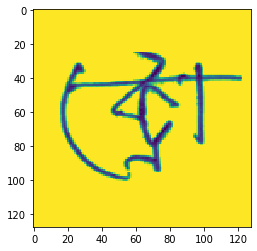

In [0]:
d = data[0]
plt.imshow(d)

In [0]:
img = 255 - (d*(255.0/d.max())).astype(np.uint8)
img = crop_resize(img)
plt.imshow(255-img)

(128, 128)

In [0]:
img-255

(50210, 137, 236)

In [0]:
df.shape

(50210, 32333)

In [0]:
out

,image_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,16344,16345,16346,16347,16348,16349,16350,16351,16352,16353,16354,16355,16356,16357,16358,16359,16360,16361,16362,16363,16364,16365,16366,16367,16368,16369,16370,16371,16372,16373,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,Train_0,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255
1,Train_1,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255
2,Train_2,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255
3,Train_3,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255
4,Train_4,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50205,Train_50205,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255
50206,Train_50206,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255
50207,Train_50207,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255
50208,Train_50208,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255


In [0]:
128*128


16384